
"""
Created on Tue Feb 22 14:42:56 2022
@author: uqczhan2
if hydraulic conductivity of the sandy layer
is reduced, the large hydraulic conductivity in the oscillating boundary
needs to be redued accordingLy_m 
"""

This example uses modflow2005

In [1]:
# -*- coding: utf-8 -*-
import sys
import glob
import platform
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
import os
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    
# a dot dict to group objects togeter
# https://stackoverflow.com/a/23689767/1744434
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [2]:
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
#print('pandas version: {}'.format(pd.__version__))
print('flopy version: {}'.format(flopy.__version__))
print('Model workspace is : {}'.format(os.getcwd()))


3.9.10 (main, Mar 21 2022, 14:53:30) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-44)]
numpy version: 1.22.3
matplotlib version: 3.5.1
flopy version: 3.3.6
Model workspace is : /storage/macondo/uqczhan2/Projects/CIVI4140_UQ/Q1_flopy


In [3]:
params= {
    'caseid': 'ah', 'kh_sand_mPday': 2.0 , 'nlay': 1,'sy': 0.03, 'strt_m': -6, 'kz_clay_mPday':  0.000847*2 , 'zbot_m': -10.
    }

In [4]:
Lx_m   = 1000.    # from plot, y is plotted from left to right
Ly_m   = 10.     # from plot, y is plotted upward
ztop_m = 0.    # top elevation of z axis (gravity)
zbot_m = -20.  # bottom elevation of z axis (gravity)
nlay = 10    # number of layers (gravity)
nrow = 1     # number of rows
ncol = 10
delr_m = Lx_m / ncol
delc_m = Ly_m / nrow
delv_m = (ztop_m - zbot_m) / nlay             # layer thickness
botm_list_m = np.linspace(ztop_m, zbot_m, nlay + 1)  # layer elevation array
kh_mPday=20.0
kh_lrc_list = np.ones((nlay, nrow, ncol), dtype=np.int32) * kh_mPday #*30.   
# making hydraulic conductivity array  [lay_row_column]
kh_lrc_list[:,:,0]= 100.     # first column has a very high hydraulic conductivity
vka_lrc_list = kh_lrc_list
sy = 0.25    # specific yield, equivalent to effective porosity
ss = 1.e-4   #  specific storitivity 
laytyp = np.ones(nlay)   # unconfined = 1 

In [5]:
# interesting to see that the it is better to be converged, if the head is above zero 
strt_m = -15. * np.ones((nlay, nrow, ncol), dtype=np.float32)   # initial hydraulic head
nper   = 3                  # number of stress periods
nstp = 200  # 100 as default
perlen= 100
perlen_list = [perlen, perlen, perlen]    # length of stress periods  days 
nstp_list   = [nstp, nstp, nstp]    # number of steps per stress periods
steady = [False, False, False]   # if the results needs to be in steady state

In [6]:
modelname = 'tutorial2'
# mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')
# dis = flopy.modflow.ModflowDis(mf, 
#                                nlay, 
#                                nrow, 
#                                ncol, 
#                                delr=delr_m, 
#                                delc=delc_m,
#                                top=ztop_m, botm=botm_list_m[1:],
#                                nper=nper, perlen=perlen, nstp=nstp_list, steady=steady,
#                                itmuni=4)   #itmuni 4 means time unit is days

tsmult_ay_day = np.ones(nper) + perlen # length of stress periods  days 
nstp_ay       = np.ones(nper,dtype=int) + nstp
tsmult        = np.ones(nper)
bool_steady_state_stress_period_ay = np.zeros(nper,dtype=bool)
dis_perioddata_ay = []
for i in np.arange(nper):
    dis_perioddata_ay.append([tsmult_ay_day[i],nstp_ay[i],tsmult[i]])
ws = os.path.abspath('./Model/')
sim = flopy.mf6.MFSimulation(sim_name=modelname, 
                             version='mf6',
                             sim_ws=ws)
tdis = flopy.mf6.ModflowTdis(sim, 
                             time_units='DAYS',
                             nper=nper, 
                             perioddata=dis_perioddata_ay
                            )
#bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
# dis
fModName = 'FlowModel'
gwf = flopy.mf6.ModflowGwf(sim, 
                           modelname  =  fModName, 
                           newtonoptions  = True)


In [7]:
# def get_lrc_from_coordinates(x,y,z,dis=dis) :
#     """
#     function to get the lrc of the coordinates. 
#     """
#     [row,column]= dis.get_rc_from_node_coordinates(x,y)
#     layer = dis.get_layer(row,column,z)
#     return (layer, row , column)

point_chd = dotdict({'x':1,'y':5,'z':-20})
# (point_chd.l,point_chd.r,point_chd.c ) = get_lrc_from_coordinates(
#     point_chd['x'],
#     point_chd['y'],
#     point_chd['z'])
# point_chd.r , point_chd.c   = gwf.modelgrid.intersect(
#     point_chd.x, 
#     point_chd.y, 
#     point_chd.z,
#     #local=True
#     )
# still, we have yet got good results on this.
point_chd.l = nlay - 1 
point_chd.r = 0 
point_chd.c = 0 
point_chd.head_stressperiod_ay_m = [-1.1, -10, -0.1]
#gwf.modelgrid.get
# a = gwf.modelgrid.intersect(
#     point_chd.x, 
#     point_chd.y, 
#     point_chd.z, 
#     #local=True
#     )
# x = point_chd.x
# y = point_chd.y
# z = point_chd.z

#ibound = np.zeros((nlay, nrow, ncol), dtype=np.int32) + 3    # [lay_row_column] active cell has ibound of 3
# lay_id_chd = nlay-1  # the cell at bottom left will be prescribed with chd package.  
# row_id_chd = 0
# col_id_chd = 0
idomain_chd = 1  # the cell prescibed with chd package are masked with ibound of 1
# # why 3-D here?? because the model is 3-d, with one row
#ibound[point_chd['l'],point_chd['r'],point_chd['c']] = ibound_chd   

In [8]:
#  ims package
nouter, ninner = 700, 300
hclose, rclose, relax = 1e-8, 1e-6, 0.97   # convergene criteria
imsgwf = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                  outer_dvclose=hclose,
                                  outer_maximum=nouter,
                                  under_relaxation='NONE',
                                  inner_maximum=ninner,
                                  inner_dvclose=hclose, 
                                  rcloserecord=rclose,
                                  linear_acceleration='BICGSTAB',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  filename='{}.ims'.format(fModName))

In [9]:
idomain_lrc_ay = np.full((nlay, nrow, ncol), 3) # similar to idomain where 0 means inactive cell, 1 means active cell
idomain_lrc_ay[point_chd.l][point_chd.r][point_chd.c] = idomain_chd
dis = flopy.mf6.ModflowGwfdis(gwf, 
                              nlay = nlay, 
                              nrow = nrow, 
                              ncol = ncol,
                              delr = delr_m, 
                              delc = delc_m,
                              top  = ztop_m, 
                              botm = botm_list_m[1:], 
                              idomain = idomain_lrc_ay   # temperorily presscribed
                              )

In [10]:
# reserved for github questions
#layer, row, column = gwf.modelgrid.intersect(x, y, z, local=True)
#layer, row, column = gwf.modelgrid.intersect(x, y, z)
#print (layer,row,column)
#lrc = gwf.modelgrid.intersect(x, y, z)
#print (lrc)

In [11]:
# https://modflowpy.github.io/flopydoc/mflpf.html
head_dry_m=1e-30
# wetfct (float) – is a factor that is included in the
#calculation of the head that is initially established at
#a cell when it is converted from dry to wet. (default is 0.1).
wetfct =0.1 #0.05

# iwetit (int) – is the iteration interval for attempting to wet cells.
# Wetting is attempted every IWETIT iteration. If using the PCG solver (Hill, 1990), 
# his applies to outer iterations, 
# not inner iterations. If IWETIT less than or equal to 0, it is changed to 1. (default is 1).
iwetit = 3

# laywet (int or array of ints (nlay)) – contains a flag for each layer that indicates 
# if wetting is active. 0 wetting is inactive not 0 wetting is active (default is 0).
laywet = 1 

# wetdry (float or array of floats (nlay, nrow, ncol)) – is a combination of the wetting 
# threshold and a flag to indicate which neighboring cells can cause a cell to become wet. 
# (default is -0.01).
wetdry = -0.01 #-1

# lpf = flopy.modflow.ModflowLpf(mf, 
#                                hk  = hk, 
#                                vka = vka, 
#                                sy  = sy, 
#                                ss  = ss, 
#                                laytyp = laytyp, 
#                                ipakcb = 53,
#                                hdry   = head_dry_m,
#                                wetfct = wetfct,
#                                iwetit = iwetit,
#                                laywet = laywet,
#                                wetdry = wetdry)
# pcg = flopy.modflow.ModflowPcg(mf)


# #k33 ([double]) –
#k33 (double) is the hydraulic conductivity of the third ellipsoid axis (or the ratio of K33/K if the
# K33OVERK option is specified); for an unrotated case, this is the vertical hydraulic conductivity.
# When anisotropy is applied, K33 corresponds to the K33 tensor component. All included cells (IDOMAIN > 0) must have a K33 value greater than zero.
# icelltype (integer) flag for each cell that specifies how saturated thickness is treated. 0 means saturated thickness is held constant; 
#:math:`>`0 means saturated thickness varies with computed head when head is below the cell top; 
#:math:`<`0 means saturated thickness varies with computed head unless the THICKSTRT option is in effect. 
# When THICKSTRT is in effect, a negative value of icelltype indicates that saturated thickness will be computed as STRT-BOT and held constant.
# k22 is equal to k by default
npf = flopy.mf6.ModflowGwfnpf(gwf,
                              xt3doptions = False,
                              save_flows = True,
                              save_specific_discharge = True,
                              icelltype = 1,   # meaning that transmissivity changes with heads
                              k   = kh_lrc_list, 
                              k33 = vka_lrc_list)
# iconvert (integer) is a flag for each cell that specifies 
# whether or not a cell is convertible for the storage 
# calculation. 0 indicates confined storage is used. 
# :math:`>`0 indicates confined storage is used when head is 
# above cell top and a mixed formulation of unconfined and 
# confined storage is used when head is below cell top.
sto = flopy.mf6.ModflowGwfsto(gwf, 
                              sy = sy, 
                              ss = ss, 
                              iconvert = 1
                              )
# # https://modflowpy.github.io/flopydoc/mflpf.html
ic = flopy.mf6.ModflowGwfic(gwf, 
                            strt = strt_m)

Text(0.5, 1.0, 'idomain values')

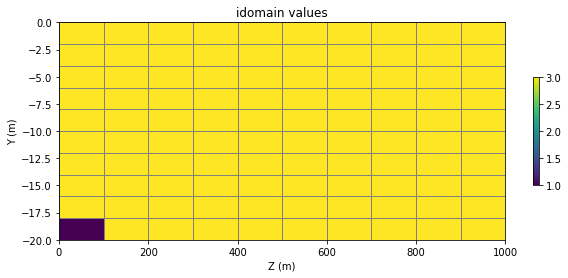

In [12]:
# plot idomain values at yz section

fig = plt.figure(figsize=(10, 4))
ax  = fig.add_subplot(1, 1, 1)
modeLx_msect = flopy.plot.PlotCrossSection(model=gwf, line={'Row': 0})
arr = modeLx_msect.plot_array(idomain_lrc_ay)
modeLx_msect.plot_grid()
plt.colorbar(arr, shrink=0.5, ax=ax)
ax.set_ylabel("Y (m)")
ax.set_xlabel("Z (m)")
ax.set_title("idomain values")
#ax.legend()

In [13]:
# constant head package


# boundary_constant_head_m = strt_m
# for i in list(set(adline_chd.gridgen_intersect.nodenumber)):
#     coord= gwf.modelgrid.get_lrc(i)
#     chd_spd.append(  [ (0 , coord[0][1], coord[0][2]) , 
#                       boundary_constant_head_m  ] )

chd_spd_dict = {}
for per in np.arange(nper):
       chd_spd = []
       chd_spd.append(  [ (point_chd.l , point_chd.r, point_chd.c) , 
                      point_chd.head_stressperiod_ay_m[per]  ] )
       chd_spd_dict[per] = chd_spd
    
    
chd = flopy.mf6.ModflowGwfchd(
    gwf,
    stress_period_data=chd_spd_dict,
)
    
# ibound_chd_mask = np.ma.masked_equal(ibound,ibound_chd)
# chd_node_index = np.where(ibound_chd_mask.mask)
# stress_period_data = {}
# bound_sp0 = []
# for i in np.arange(np.sum(ibound_chd_mask.mask)):
#    bound_sp0.append([chd_node_index[0][i], chd_node_index[1][i], chd_node_index[2][i] , -1 , -1]  )
# bound_sp1=[]
# for i in np.arange(np.sum(ibound_chd_mask.mask)):
#    bound_sp1.append([chd_node_index[0][i],chd_node_index[1][i],chd_node_index[2][i],-10,-10]  )
# bound_sp2=[]
# for i in np.arange(np.sum(ibound_chd_mask.mask)):
#    bound_sp2.append([chd_node_index[0][i],chd_node_index[1][i],chd_node_index[2][i],-0.1,-0.1]  )

# stress_period_data={0:bound_sp0,1:bound_sp1,2:bound_sp2}

# chd=flopy.modflow.mfchd.ModflowChd(model=mf,
#                                    stress_period_data=stress_period_data)

In [14]:
oc = flopy.mf6.ModflowGwfoc(gwf,
                   budget_filerecord ='{}.cbc'.format(fModName),
                   head_filerecord   ='{}.hds'.format(fModName),
                   headprintrecord   =[
                                ('COLUMNS', 10, 'WIDTH', 15,
                                 'DIGITS', 6, 'GENERAL')],
                   saverecord=[('HEAD', 'ALL'),
                               ('BUDGET', 'ALL')],
                   printrecord=[('HEAD', 'LAST'),
                                ('BUDGET', 'LAST')])
# stress_period_data = {}
# for kper in range(nper):
#     for kstp in range(nstp_list[kper]):
#         if np.mod(kstp,2)==0:
#             stress_period_data[(kper, kstp)] = ['save head',
#                                                 'save drawdown',
#                                                 'save budget',
#                                                 'print head',
#                                                 'print budget']
            
# oc = flopy.modflow.ModflowOc(mf, stress_period_data=stress_period_data,compact=True)

In [15]:
sim.write_simulation(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model FlowModel...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package sto...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...


#### Run the model

In [18]:
# success, mfoutput = mf.run_model(silent=True, pause=False, report=True)
# if not success:
#         raise Exception('MODFLOW did not terminate normalLy_m.')
try:
    os.remove(os.path.join(model_ws, "{0}.hds".format(modelname)))
except:
    pass
success,mfoutput = sim.run_simulation(silent=False, pause=False,report=True) #mfoutput = mf.run_model(silent=True, pause=False, report=True)
if not success:
        raise Exception('MODFLOW did not terminate normalLy_m.')

/storage/macondo/uqczhan2/Projects/CIVI4140_UQ/Q1_flopy/Model
mf6.exe
/storage/macondo/uqczhan2/bin/mf6.exe
FloPy is using the following executable to run the model: /storage/macondo/uqczhan2/bin/mf6.exe
mf6.exe: error while loading shared libraries: libgfortran.so.5: cannot open shared object file: No such file or directory


Exception: MODFLOW did not terminate normalLy_m.

In [ ]:
headobj = bf.HeadFile(modelname+'.hds')
times_headobj = headobj.get_times()
cbbobj = bf.CellBudgetFile(modelname+'.cbc')
times_cbbobj = cbbobj.get_times()
# beginning of the first stress period
times_output_list_day = np.array([98, 100.0, 150,198,200,250,298])  + perlen /  float(nstp)

print(times_cbbobj)

In [ ]:
print(times_headobj)

In [ ]:
tsList = headobj.get_kstpkper()
head_array_timeid_lrc_m = np.empty([len(times_cbbobj)],object)
for i,j in enumerate(times_cbbobj):
    #print(i,j)
    head_array_timeid_lrc_m[i]=  headobj.get_data(totim=j)

In [ ]:
print(tsList)

In [ ]:
np.set_printoptions(suppress=False,precision=2)  #organise the matrix output better

In [ ]:
def plot_head_distribution_watertable(output_time_index = 1):
    fig = plt.figure(figsize=(8, 3))
    ax  = fig.add_subplot(1, 1, 1)
    t   = ax.set_title('Head distribution at  day %i' %(times_output_list_day[output_time_index]))
    head = headobj.get_data(totim=times_output_list_day[output_time_index])
    modeLx_msect = flopy.plot.PlotCrossSection(model=mf, line={'Row': 0})
    arr = modeLx_msect.plot_array(head,masked_values= [head_dry_m])
    grd = modeLx_msect.plot_grid()
    ax.plot(dis.get_node_coordinates()[1] , head[-1,0,:], linewidth=5.0,)
    plt.colorbar(arr, shrink=1, ax=ax)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')
    times = cbbobj.get_times()
    qx = cbbobj.get_data(text="flow right face", totim=times[output_time_index])[0]
    qy = np.zeros((nlay, nrow, ncol), dtype=float)
    qz = cbbobj.get_data(text="flow lower face", totim=times[output_time_index])[0]
    modeLx_msect.plot_vector(qx, qy, -qz, color="white", kstep=1, hstep=1)

Note dry cells are given as non-colored cells

In [ ]:
plot_head_distribution_watertable(output_time_index = 0)

In [ ]:
plot_head_distribution_watertable(output_time_index = 1)

In [ ]:
plot_head_distribution_watertable(output_time_index = 2)

In [ ]:
plot_head_distribution_watertable(output_time_index = 3)

In [ ]:
plot_head_distribution_watertable(output_time_index = 4)

In [ ]:
plot_head_distribution_watertable(output_time_index = 5)

In [ ]:
plot_head_distribution_watertable(output_time_index = 6)

In [ ]:
head_array_301_m =np.array([i[3,0,1] for i in head_array_timeid_lrc_m[:]])
print(head_array_301_m)

In [ ]:
# find the lrc of some key point and extrat the head at the point over time.

point_1 = {'x':500,'y':5,'z':-15}
(point_1['l'],point_1['r'],point_1['c'] )= get_lrc_from_coordinates(
    point_1['x'],
    point_1['y'],
    point_1['z'])
point_1['head_time_ay']=np.array(
    [ i[point_1['l'],point_1['r'],point_1['c']] for i in head_array_timeid_lrc_m ])
point_1 ['label']= 'x={:1.1e}'.format(point_1['x']) +  ', z={:1.1e}'.format(point_1['z'])


point_chd['head_time_ay']=np.array(
    [ i[point_chd['l'],point_chd['r'],point_chd['c']] for i in head_array_timeid_lrc_m ])
point_chd ['label']= 'x={:1.1e}'.format(point_chd['x']) +  ', z={:1.1e}'.format(point_chd['z'])

point_2 = {'x':1000,'y':5,'z':-15}
(point_2['l'],point_2['r'],point_2['c'] )= get_lrc_from_coordinates(
    point_2['x'],
    point_2['y'],
    point_2['z'])
point_2['head_time_ay']=np.array(
    [ i[point_2['l'],point_2['r'],point_2['c']] for i in head_array_timeid_lrc_m ])
point_2 ['label']= 'x={:1.1e}'.format(point_2['x']) +  ', z={:1.1e}'.format(point_2['z'])

point_3 = {'x':200,'y':5,'z':-5}
(point_3['l'],point_3['r'],point_3['c'] )= get_lrc_from_coordinates(
    point_3['x'],
    point_3['y'],
    point_3['z'])
point_3['head_time_ay']=np.array(
    [ i[point_3['l'],point_3['r'],point_3['c']] for i in head_array_timeid_lrc_m ])
point_3 ['label']= 'x={:1.1e}'.format(point_3['x']) +  ', z={:1.1e}'.format(point_3['z'])
point_3['head_time_ay'][point_3['head_time_ay'] == head_dry_m]= np.nan

In [ ]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=1,
    sharex=True,
    figsize=(8.3, 4.3),
    constrained_layout=True,
)

title_str ='kh = {:1.1e}'.format(kh_mPday) + '_ nlay = {:1.1e}'.format(nlay) \
    +'_ sy = {:1.1e}'.format(sy) + '_ wetfct = {:1.1e}'.format(wetfct) \
    + '_ nstp = {:1.1e}'.format(nstp)+ '_ wetdry = {:1.1e}'.format(wetdry)
    
fig.suptitle(title_str,fontsize=10)

ax = axes[0]
# ax.set_ylim(110, 130)

ax.plot(
    times_headobj,
    point_chd['head_time_ay'],
    lw=1.75,
    ls="-",
    color="red",
    label=point_chd ['label'],
)

ax.plot(
    times_headobj,
    point_1['head_time_ay'],
    lw=1.75,
    ls="-",
    color="green",
    label=point_1 ['label'],
)

ax.plot(
    times_headobj,
    point_2['head_time_ay'],
    lw=1.75,
    ls="-",
    color="blue",
    label=point_2 ['label'],
)

ax.plot(
    times_headobj,
    point_3['head_time_ay'],
    lw=1.75,
    ls="-",
    color="cyan",
    label=point_3 ['label'],
)

ax.legend(loc="lower right",fontsize=10)
ax.set_title("Head over time at fixed points")    
ax.set_ylabel("Head in Metres")
ax.set_xlabel("Time (days)")
ax.grid()
axes[0].set_xlim([0, times_cbbobj[-1]])
# fs.graph_legend(ax, loc="upper right")
# fs.heading(ax, idx=0)

ax = axes[1]

head_idx=0;head = headobj.get_data(totim=times_output_list_day[head_idx])
ax.plot(dis.get_node_coordinates()[1] , 
        head[-1,0,:], 
        linewidth=2.0,
        color='red',
        label= "day " + str(times_output_list_day[head_idx]),
       )
head_idx=1;head = headobj.get_data(totim=times_output_list_day[head_idx])
ax.plot(dis.get_node_coordinates()[1] , 
        head[-1,0,:], 
        linewidth=2.0,
        color='green',
        label= "day " + str(times_output_list_day[head_idx]),
       )
head_idx=2;head = headobj.get_data(totim=times_output_list_day[head_idx])
ax.plot(dis.get_node_coordinates()[1] , 
        head[-1,0,:], 
        linewidth=2.0,
        color='blue',
        label= "day " + str(times_output_list_day[head_idx]),
       )
head_idx=3;head = headobj.get_data(totim=times_output_list_day[head_idx])
ax.plot(dis.get_node_coordinates()[1] , 
        head[-1,0,:], 
        linewidth=2.0,
        color='cyan',
        label= "day " + str(times_output_list_day[head_idx]),
       )
head_idx=4;head = headobj.get_data(totim=times_output_list_day[head_idx])
ax.plot(dis.get_node_coordinates()[1] , 
        head[-1,0,:], 
        linewidth=2.0,
        color='brown',
        label= "day " + str(times_output_list_day[head_idx]),
       )
head_idx=5;head = headobj.get_data(totim=times_output_list_day[head_idx])
ax.plot(dis.get_node_coordinates()[1] , 
        head[-1,0,:], 
        linewidth=2.0,
        color='black',
        label= "day " + str(times_output_list_day[head_idx]),
       )
head_idx=6;head = headobj.get_data(totim=times_output_list_day[head_idx])
pl=ax.plot(dis.get_node_coordinates()[1] , 
        head[-1,0,:], 
        linewidth=2.0,
        color='gray',
        label= "day " + str(times_output_list_day[head_idx]),
       )
ax.grid()
ax.legend(loc="upper right",fontsize=10)
ax.set_title("Head at the bottom layer at specific points")    
ax.set_ylabel("Head in Metres")
ax.set_xlabel("X (m)")
#ax.set_xlim([0, Lx_m])
#axes.axes.set_xlim([0, 300])
axes[1].set_xlim([0, 1000])
fname_save=title_str.replace(';', ' ').replace('+', '').replace('e-', 'ne') \
    .replace('=', '_').replace(' ', '')
print(fname_save)
plt.savefig(fname_save+'.png',dpi=300)

In [ ]:
dis.get_lrc(5)


In [ ]:
dis.get_node_coordinates()[2]

In [ ]:
def get_lrc_from_coordinates(x,y,z,dis=dis) :
    """
    function to get the lrc of the coordinates. 
    """
    [row,column]= dis.get_rc_from_node_coordinates(x,y)
    layer = dis.get_layer(row,column,z)
    return (layer, row , column)

In [ ]:
dis.get_layer(0,4,-15)